In [ ]:
import tensorflow as tf
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.5.0


In [ ]:
!git clone --depth 1 -b v2.5.0 https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 958, done.
remote: Counting objects: 100% (958/958), done.
remote: Compressing objects: 100% (773/773), done.
remote: Total 958 (delta 254), reused 352 (delta 172), pack-reused 0
Receiving objects: 100% (958/958), 1.48 MiB | 10.11 MiB/s, done.
Resolving deltas: 100% (254/254), done.
Note: checking out '4f0e20f26d79610b7dbcf4c103dbd53c456a8348'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>



In [ ]:
!pip install -Uqr models/official/requirements.txt

     |████████████████████████████████| 7.1MB 9.6MB/s 
     |████████████████████████████████| 194kB 30.3MB/s 
     |████████████████████████████████| 15.7MB 186kB/s 
     |████████████████████████████████| 10.8MB 40.8MB/s 
     |████████████████████████████████| 296kB 40.7MB/s 
     |████████████████████████████████| 102kB 12.1MB/s 
     |████████████████████████████████| 28.5MB 94kB/s 
     |████████████████████████████████| 215kB 44.0MB/s 
     |████████████████████████████████| 3.9MB 40.9MB/s 
     |████████████████████████████████| 686kB 29.5MB/s 
     |████████████████████████████████| 358kB 39.9MB/s 
     |████████████████████████████████| 2.0MB 31.0MB/s 
     |████████████████████████████████| 10.3MB 33.6MB/s 
     |████████████████████████████████| 645kB 35.6MB/s 
     |████████████████████████████████| 37.2MB 79kB/s 
     |████████████████████████████████| 3.0MB 46.0MB/s 
     |████████████████████████████████| 51kB 6.2MB/s 
     |████████████████████████████████| 1.2MB 27.3M

In [ ]:
#after restart the runtime

import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')

from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

In [ ]:
print("TF Version: ", tf.__version__)
print("Eager Mode: ", tf.executing_eagerly())
print("Hub Version: ", hub.__version__)
print("GPU is", "available." if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE.")

TF Version:  2.5.0
Eager Mode:  True
Hub Version:  0.12.0
GPU is NOT AVAILABLE.


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv('https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip', compression = 'zip', low_memory = False)
df.shape

(1306122, 3)

In [ ]:
df.head(5)

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


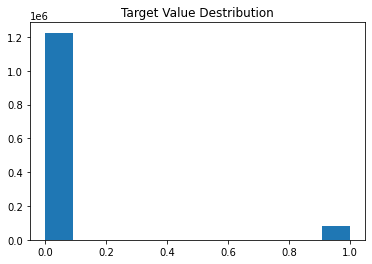

In [ ]:
import matplotlib.pyplot as plt
plt.hist(df.target, bins=11)
plt.title("Target Value Destribution")
plt.show()

In [ ]:
train_df, remaining = train_test_split(df, random_state = 42, train_size = 0.0075, stratify = df.target.values)
valid_df, _ = train_test_split(remaining, random_state = 42, train_size = 0.00075, stratify = remaining.target.values)
train_df.shape, valid_df.shape

((9795, 3), (972, 3))

In [ ]:
with tf.device('/cpu:0'):
  train_data = tf.data.Dataset.from_tensor_slices((train_df['question_text'].values, train_df['target'].values))
  valid_data = tf.data.Dataset.from_tensor_slices((valid_df.question_text.values, valid_df.target.values))

  for text, label in train_data.take(1):
    print(text)
    print(label)

tf.Tensor(b'Why are unhealthy relationships so desirable?', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


In [ ]:
label_list = [0, 1] #based on target value catagories
max_seq_length = 128
train_batch_size = 32

#Get BERT layer and Tokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2",
                            trainable=True)

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
tokenizer.wordpiece_tokenizer.tokenize('Hi, How are you doing?') #showing the token

['[UNK]', '[UNK]', 'are', 'you', 'doing', '##?']

In [ ]:
#Convert to Token IDs that BERT requires
tokenizer.convert_tokens_to_ids(tokenizer.wordpiece_tokenizer.tokenize('Hi, How are you doing?'))

[100, 100, 2024, 2017, 2725, 29632]

In [ ]:
#This function convert the raw to input features and label
def to_feature(text, label, label_list = label_list, max_seq_length = max_seq_length, tokenizer = tokenizer):
  example = classifier_data_lib.InputExample(guid = None,
                                             text_a = text.numpy(),
                                             text_b = None,
                                             label = label.numpy())
  feature = classifier_data_lib.convert_single_example(0, example, label_list, max_seq_length, tokenizer)

  return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)

In [ ]:
#wrapper function
def to_feature_map(text, label):
  input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature,inp = [text, label],
                                                                Tout = [tf.int32, tf.int32, tf.int32, tf.int32])
  input_ids.set_shape([max_seq_length])
  input_mask.set_shape([max_seq_length])
  segment_ids.set_shape([max_seq_length])
  label_id.set_shape([])

  x = {
      'input_word_ids': input_ids,
       'input_mask': input_mask,
       'input_type_ids': segment_ids
  }

  return (x, label_id)

In [ ]:
#Tensorflow Input Pipeline
with tf.device('/cpu:0'):
  #train
  train_data = (train_data.map(to_feature_map,
                               num_parallel_calls = tf.data.experimental.AUTOTUNE)
  .shuffle(1000)
  .batch(32, drop_remainder = True)
  .prefetch(tf.data.experimental.AUTOTUNE))
  #valid
  valid_data = (valid_data.map(to_feature_map,
                               num_parallel_calls = tf.data.experimental.AUTOTUNE)
  .batch(32, drop_remainder = True)
  .prefetch(tf.data.experimental.AUTOTUNE))

In [ ]:
#train data specification
train_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [ ]:
#valid data specification
valid_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [ ]:
def create_model():
  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
  input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="input_type_ids")
  
  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])

  drop = tf.keras.layers.Dropout(0.4)(pooled_output)
  output = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'output')(drop)

  model = tf.keras.Model(
      inputs = {
          'input_word_ids': input_word_ids,
          'input_mask': input_mask,
          'input_type_ids': input_type_ids
      },
      outputs = output)
  return model

In [ ]:
model = create_model()
model.compile(optimizer='adam',
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = [tf.keras.metrics.BinaryAccuracy()]) #for multiple label we will use sparse catagorical entropy instead of Binary cross entropy
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

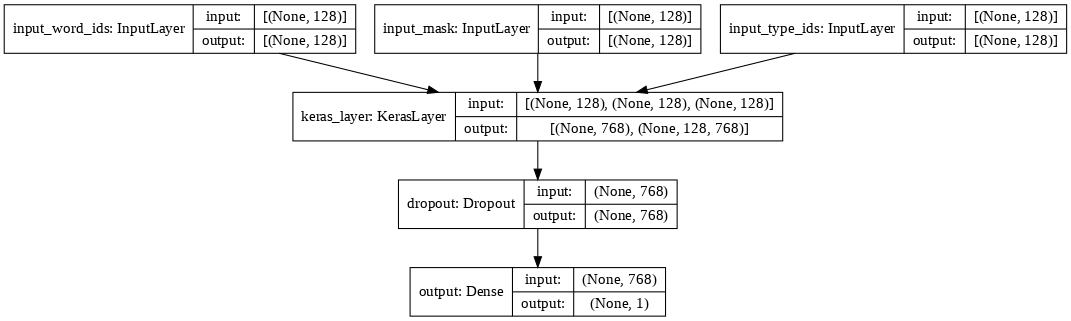

In [ ]:
tf.keras.utils.plot_model(model = model, show_shapes = True, dpi = 76)

In [ ]:
#Train Model
epochs = 1
history = model.fit(train_data,
                    validation_data = valid_data,
                    epochs = epochs,
                    verbose = 1)

259/306 [========================>.....] - ETA: 37:57 - loss: 0.2839 - binary_accuracy: 0.9286

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

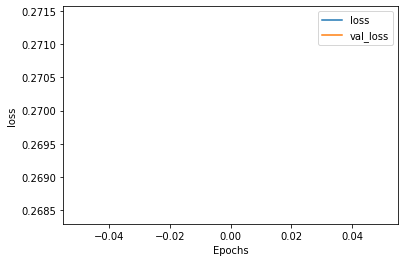

In [ ]:
plot_graphs(history, 'loss')

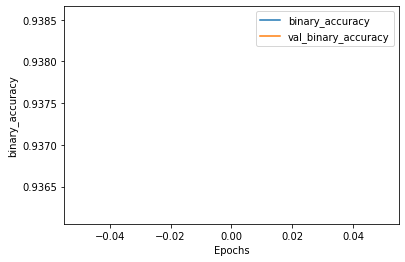

In [ ]:
plot_graphs(history, 'binary_accuracy')

In [ ]:
sample_example = ['may i have your number??', 'Can I ask my girl to go on a data after a big fight?']
test_data = tf.data.Dataset.from_tensor_slices((sample_example, [0]*len(sample_example)))
test_data = (test_data.map(to_feature_map)).batch(1)
pred = model.predict(test_data)[0][0]
threshold = 0.5
['Insincere' if pred>=threshold else 'Sincere']

['Sincere']